In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import scipy.stats as stats
import pylab
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import adfuller
import itertools 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [7]:
data = pd.read_csv(r'C:\Users\ghect\Documents\Bootcamp\Proyectos\Anova_Regresion_Lineal\seattle_weather_temperatura.csv')
data.head()

,date,temp_max
0,01/01/2012,12.8
1,02/01/2012,10.6
2,03/01/2012,11.7
3,04/01/2012,12.2
4,05/01/2012,8.9


# Examinando la data

In [10]:
data.index = pd.to_datetime(data['date'])
data.drop(columns='date',inplace=True)
data.head()

,temp_max
date,
2012-01-01,12.8
2012-02-01,10.6
2012-03-01,11.7
2012-04-01,12.2
2012-05-01,8.9


In [11]:
data_mes = data.resample('m').mean()
data_mes.head()

,temp_max
date,
2012-01-31,9.638710
2012-02-29,10.482759
2012-03-31,12.274194
2012-04-30,15.970000
2012-05-31,17.809677


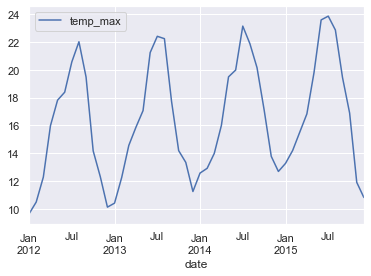

In [12]:
data_mes.plot();

# Graficando

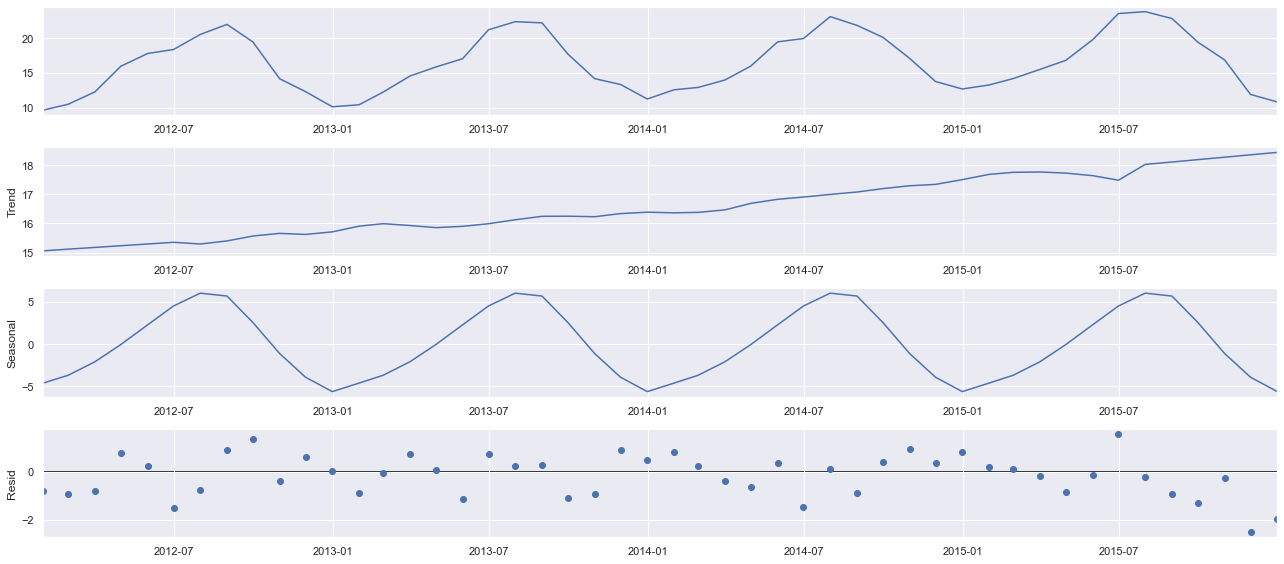

In [15]:
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
descomponer = sm.tsa.seasonal_decompose(data_mes, period=12, extrapolate_trend='freq')
#resplot = des.plot()
fig = descomponer.plot()
plt.show()

# Modelando los datos

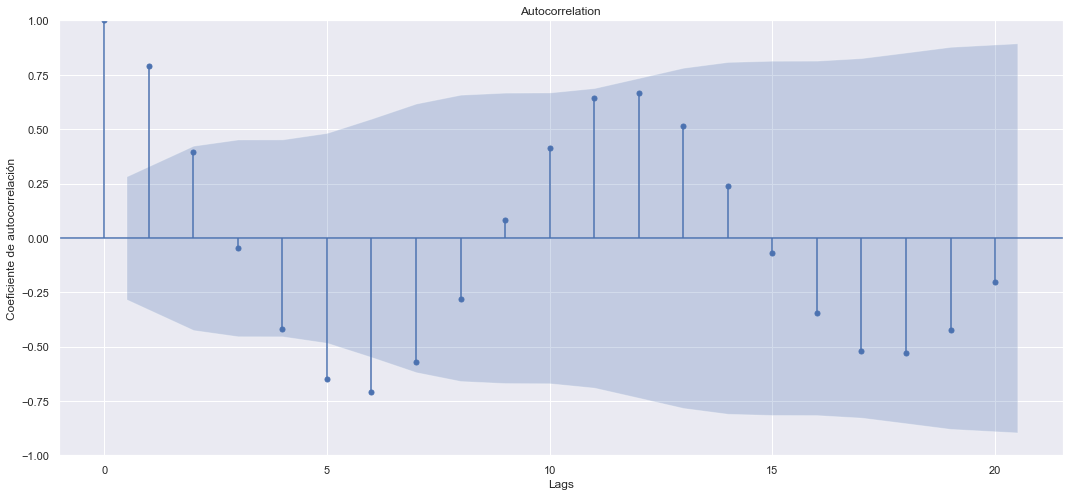

In [16]:
# Your code here:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(data_mes.values.squeeze(), lags=20)
plt.xlabel('Lags')
plt.ylabel('Coeficiente de autocorrelación')
plt.show()

# Estacionalidad

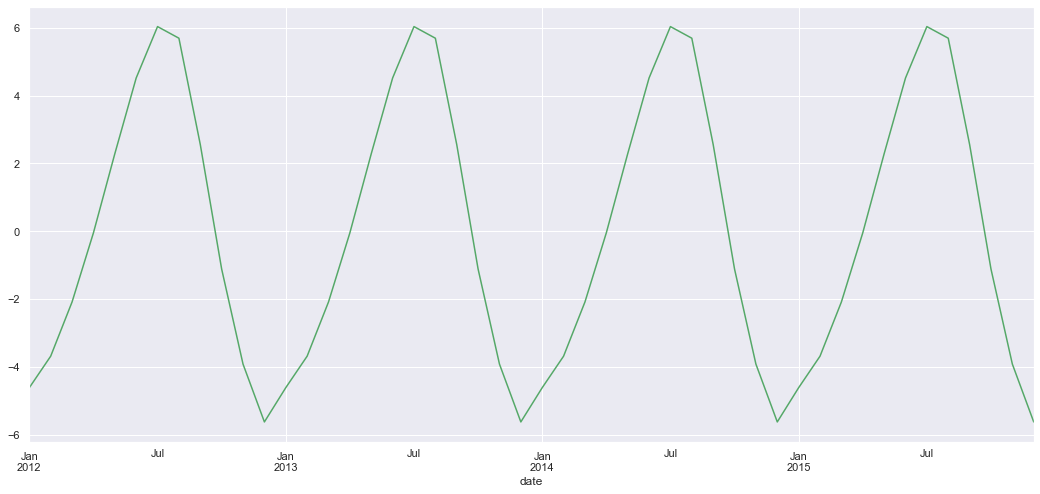

In [17]:
estacion = descomponer.seasonal
estacion.plot(color='g');

In [18]:
def viewing_stationarity(df, window=5):
  #Esta función genera un plot para una serie de tiempo con su media móvil y su desviación estándar.


    rolmean = df.rolling(window=window).mean()
    rolstd = df.rolling(window=window).std()

    fig = plt.figure(figsize=(10, 5))
    time_series = plt.plot(df, color='blue', label='original')
    mean = plt.plot(rolmean, color='red', label='media móvil')
    std = plt.plot(rolstd, color='green', label='desviación estándar móvil')
    plt.legend(loc='best')
    plt.show();

In [19]:
class Stationary:
    def __init__(self, significance=0.05):
        self.significance_level = significance
        self.pvalue = None
        self.is_stationary = None

    def ADF(self, values):
        result = adfuller(values, autolag='AIC')

        format_results = pd.Series(result[:4], 
                                    index=['Statistic', 'P-value',
                                          'Num of Lags', 'Observations'])
        for k,v in result[4].items():
              format_results[f'Critical Value {k}'] = v

        return format_results

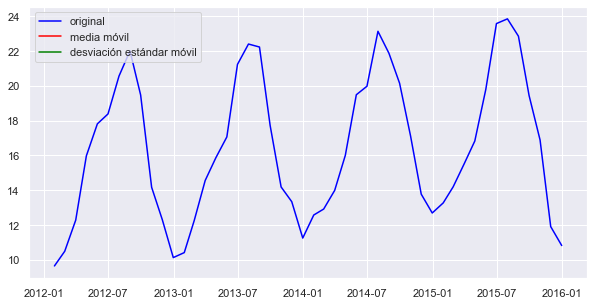

Statistic             -1.17479
P-value                0.68435
Num of Lags           10.00000
Observations          37.00000
Critical Value 1%     -3.62092
Critical Value 5%     -2.94354
Critical Value 10%    -2.61040
dtype: float64

In [20]:
viewing_stationarity(data_mes, window=60)
adf_test = Stationary()
adf_test.ADF(data_mes.values).round(5)

In [23]:
data_mes_copia = data_mes
data_mes_copia['temp_shift'] = data_mes_copia['temp_max'].shift(1) # bits = n, bits_shift1 = n-1
data_mes_copia.head()

,temp_max,temp_shift
date,,
2012-01-31,9.638710,NaN
2012-02-29,10.482759,9.638710
2012-03-31,12.274194,10.482759
2012-04-30,15.970000,12.274194
2012-05-31,17.809677,15.970000


In [24]:
data_mes_copia['temp_diff'] = data_mes_copia['temp_max'] - data_mes_copia['temp_shift']
data_mes_copia.head()

,temp_max,temp_shift,temp_diff
date,,,
2012-01-31,9.638710,NaN,NaN
2012-02-29,10.482759,9.638710,0.844049
2012-03-31,12.274194,10.482759,1.791435
2012-04-30,15.970000,12.274194,3.695806
2012-05-31,17.809677,15.970000,1.839677


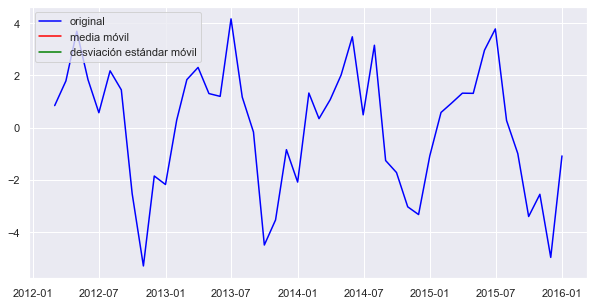

Statistic             -6.277382
P-value                0.000000
Num of Lags            9.000000
Observations          37.000000
Critical Value 1%     -3.620918
Critical Value 5%     -2.943539
Critical Value 10%    -2.610400
dtype: float64

In [25]:
viewing_stationarity(data_mes_copia['temp_diff'].dropna(), window=200)
adf_test = Stationary()
adf_test.ADF(data_mes_copia['temp_diff'].dropna().values).round(6)

# Metodo ARIMA/SARIMAX

In [26]:
model=sm.tsa.arima.ARIMA(data_mes_copia['temp_max'],order=(1,1,1))
history=model.fit()
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               temp_max   No. Observations:                   48
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -97.229
Date:                Sun, 27 Feb 2022   AIC                            200.458
Time:                        20:46:44   BIC                            206.008
Sample:                    01-31-2012   HQIC                           202.546
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5479      0.246      2.229      0.026       0.066       1.030
ma.L1          0.0676      0.288      0.235      0.814      -0.496       0.631
sigma2         3.6338      0.913      3.980      0.000       1.844       5.423
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.99
Prob(Q):                              0.87   Prob(JB):                         0.37
Heteroskedasticity (H):               1.01   Skew:                            -0.41
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
data_mes_copia.tail(12)

,temp_max,temp_shift,temp_diff
date,,,
2015-01-31,13.264516,12.683871,0.580645
2015-02-28,14.189286,13.264516,0.924770
2015-03-31,15.509677,14.189286,1.320392
2015-04-30,16.823333,15.509677,1.313656
2015-05-31,19.790323,16.823333,2.966989
2015-06-30,23.576667,19.790323,3.786344
2015-07-31,23.848387,23.576667,0.271720
2015-08-31,22.851613,23.848387,-0.996774
2015-09-30,19.440000,22.851613,-3.411613


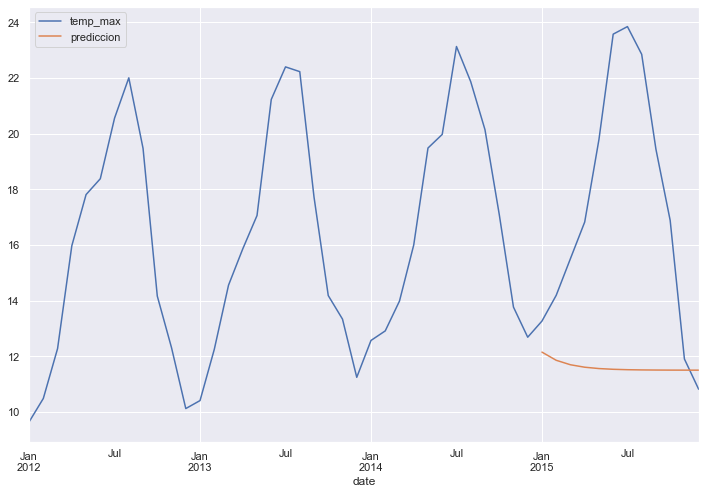

In [29]:
data_mes_copia['prediccion']=history.predict(start="2015-01-31",end="2015-12-31",dynamic=True)
data_mes_copia[['temp_max','prediccion']].plot(figsize=(12,8));

In [30]:
model=sm.tsa.arima.ARIMA(data_mes_copia['temp_diff'].dropna(),order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              temp_diff   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -99.755
Date:                Sun, 27 Feb 2022   AIC                            205.511
Time:                        20:51:00   BIC                            210.997
Sample:                    02-29-2012   HQIC                           207.566
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6783      0.580     -1.170      0.242      -1.815       0.458
ma.L1          0.5324      0.654      0.814      0.416      -0.750       1.815
sigma2         4.4733      1.253      3.570      0.000       2.017       6.929
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.99   Prob(JB):                         0.40
Heteroskedasticity (H):               0.83   Skew:                            -0.21
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

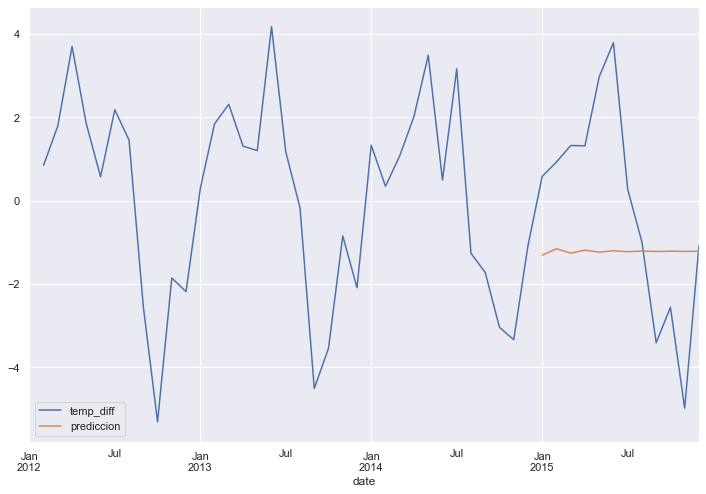

In [32]:
data_mes_copia['prediccion']=model_fit.predict(start="2015-01-31",end="2015-12-31",dynamic=True)
data_mes_copia[['temp_diff','prediccion']].plot(figsize=(12,8));

In [33]:
model=sm.tsa.statespace.SARIMAX(data_mes_copia['temp_max'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           temp_max   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -55.804
Date:                            Sun, 27 Feb 2022   AIC                            121.607
Time:                                    20:54:07   BIC                            129.384
Sample:                                01-31-2012   HQIC                           124.292
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2757      0.317      0.869      0.385      -0.346       0.897
ma.L1         -0.9572      0.567     -1.689      0.091      -2.068       0.154
ar.S.L12      -0.9079      0.701     -1.294      0.196      -2.283       0.467
ma.S.L12       0.5316      1.766      0.301      0.763      -2.930       3.993
sigma2         1.0353      0.584      1.772      0.076      -0.110       2.180
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.98   Prob(JB):                         0.49
Heteroskedasticity (H):               1.14   Skew:                            -0.49
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

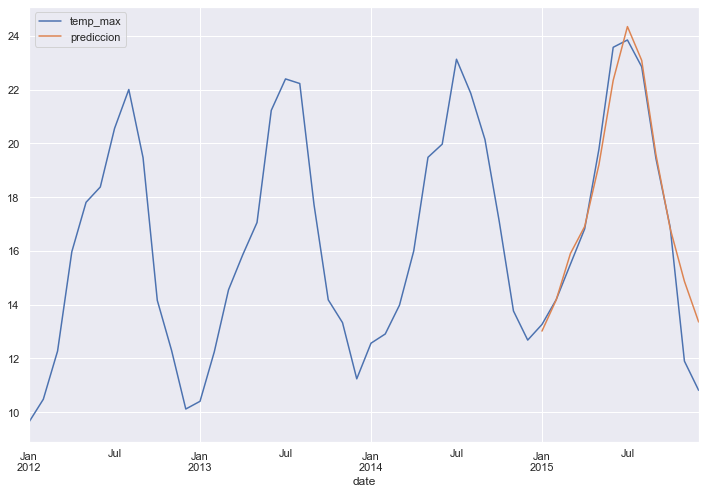

In [34]:
data_mes_copia['prediccion']=results.predict(start="2015-01-31",end="2015-12-31",dynamic=True)
data_mes_copia[['temp_max','prediccion']].plot(figsize=(12,8))

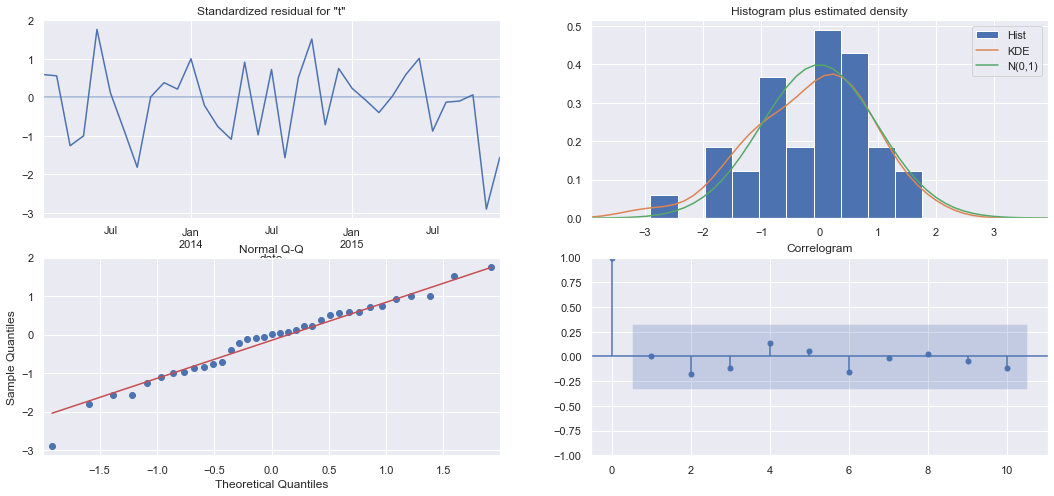

In [35]:
results.plot_diagnostics()
plt.show()

# Prediccion

In [36]:
data_mes.shape[0] * 0.80

38.400000000000006

In [37]:
data_mes.reset_index().iloc[38, 0]

Timestamp('2015-03-31 00:00:00')

In [38]:
start = data_mes.reset_index().iloc[38, 0]
end = data_mes.reset_index().iloc[-1, 0]
start, end

(Timestamp('2015-03-31 00:00:00'), Timestamp('2015-12-31 00:00:00'))

In [39]:
pred = results.predict(start=start, end=end)
pred_ci = results.get_prediction(start=start, end=end).conf_int()

df_pred = pd.DataFrame(pred, index=data_mes.iloc[38:].index, columns=['temp_max'])

In [40]:
df_pred.head()

,temp_max
date,
2015-03-31,NaN
2015-04-30,NaN
2015-05-31,NaN
2015-06-30,NaN
2015-07-31,NaN


In [41]:
pred_ci.head()

,lower temp_max,upper temp_max
date,,
2015-03-31,13.886348,17.948239
2015-04-30,14.759865,18.820810
2015-05-31,17.146524,21.206611
2015-06-30,20.496080,24.555388
2015-07-31,22.724848,26.783452


In [42]:
df_prediction = pd.concat([df_pred, pred_ci], axis=1)
df_prediction.head()

,temp_max,lower temp_max,upper temp_max
date,,,
2015-03-31,NaN,13.886348,17.948239
2015-04-30,NaN,14.759865,18.820810
2015-05-31,NaN,17.146524,21.206611
2015-06-30,NaN,20.496080,24.555388
2015-07-31,NaN,22.724848,26.783452


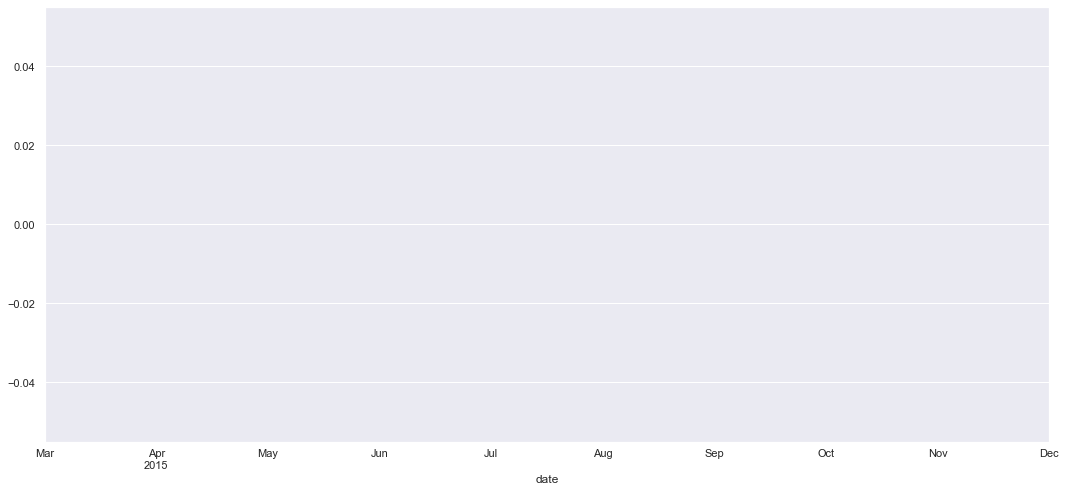

In [43]:
df_prediction['temp_max'].plot();

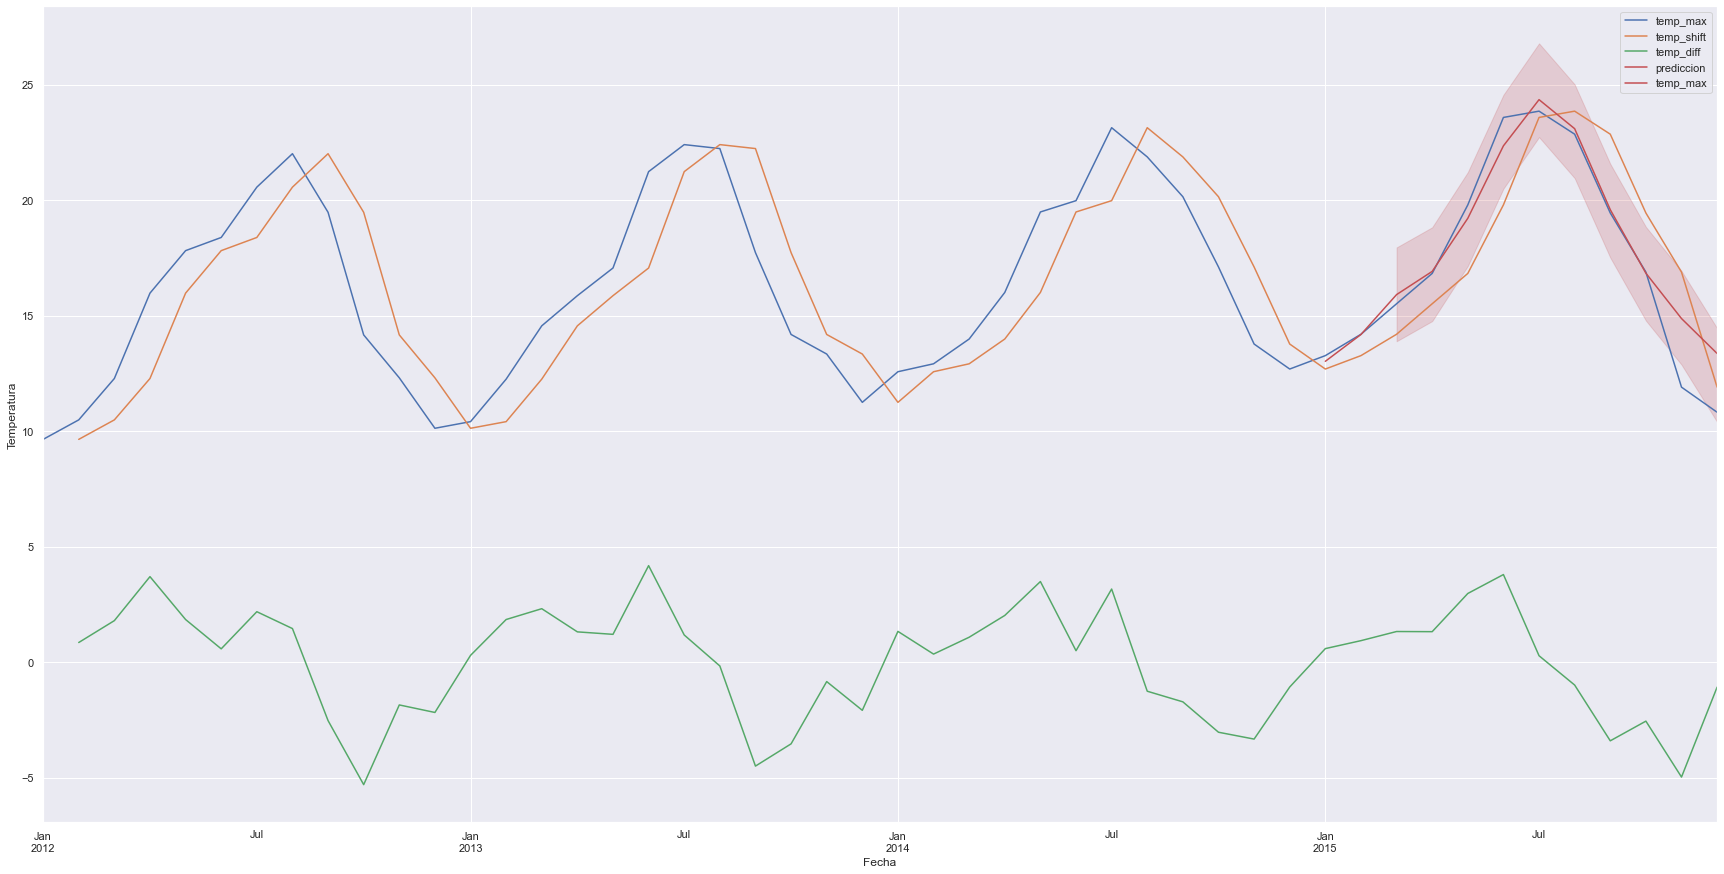

In [45]:
rcParams['figure.figsize'] = 30, 15
ax = data_mes.plot(label='observed')
df_prediction['temp_max'].plot(c='r')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.2)

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura')
plt.legend()

plt.show()

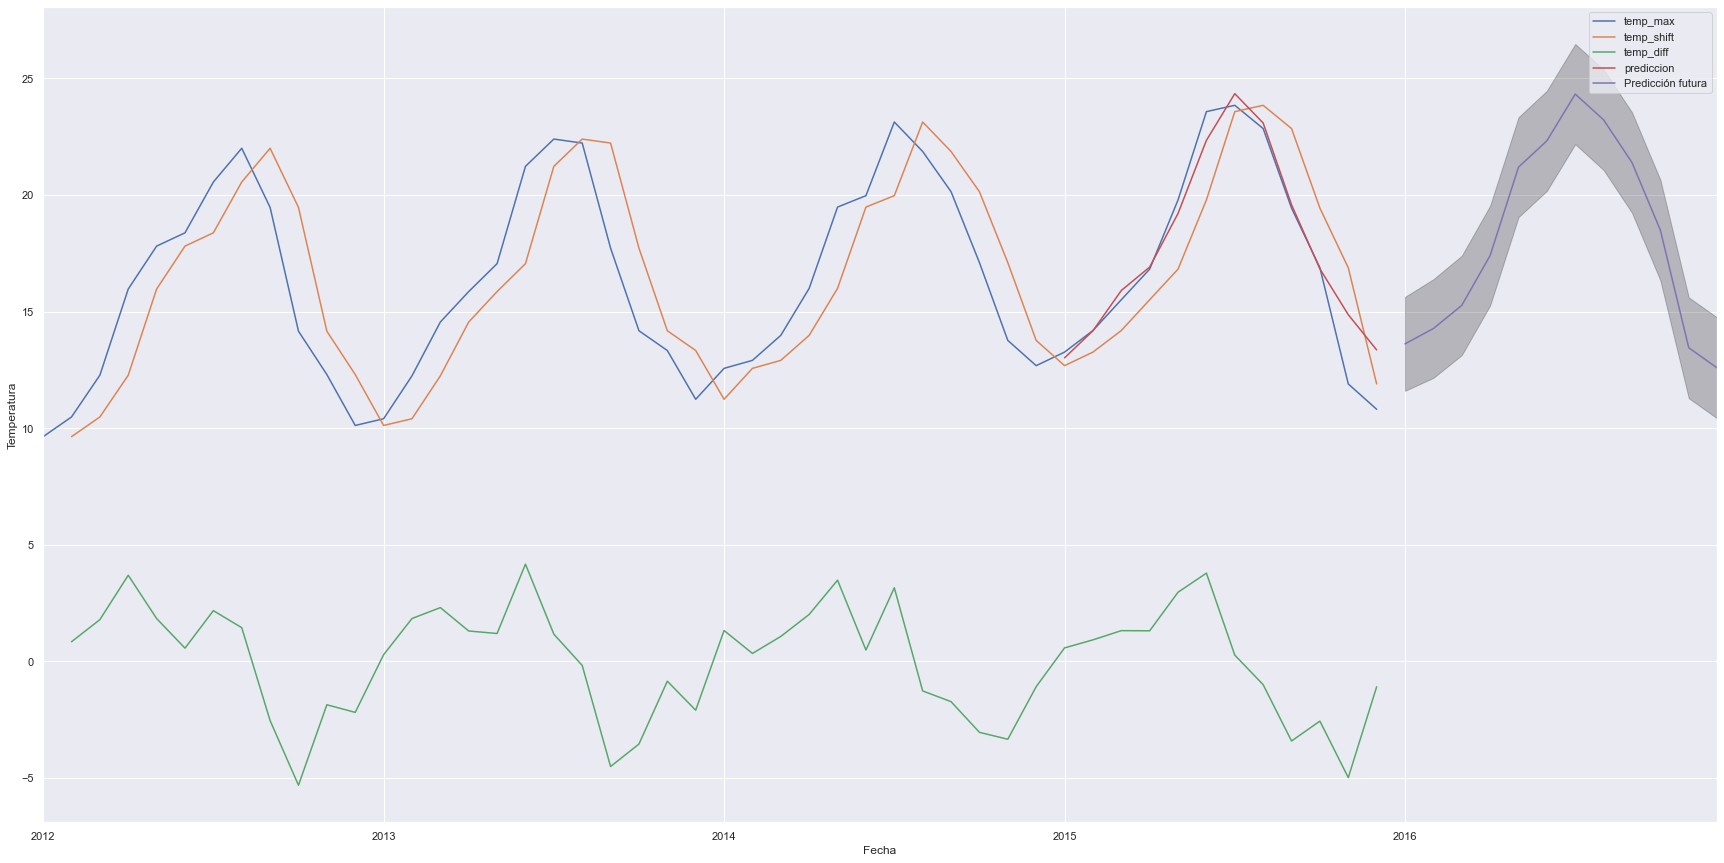

In [49]:
rcParams['figure.figsize'] = 30, 15

pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()
ax = data_mes.plot(label='Observado', figsize=(30, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Predicción futura')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura')
plt.legend()
plt.show()